## Set images

In [1]:
%%time
from utils.FloorplanToBlenderLib import *
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
from IPython.display import display

# Set image path
img_path = "Images/test5.jpg"

# Read floorplan image
img = cv2.imread(img_path)

# Create blank image
height, width, channels = img.shape
blank_image = np.zeros((height,width,3), np.uint8)

# Grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, contour_img = detect.detectOuterContours(gray, blank_image, color=(255, 0, 0))

gray_wall_filter = detect.wall_filter(gray)

gray_wall_filter = ~gray_wall_filter

rooms, colored_rooms = detect.find_rooms(gray_wall_filter.copy())

gray_rooms =  cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)

# get box positions for rooms
boxes_rooms, room_img = detect.detectPreciseBoxes(gray_rooms, gray_rooms)


# create wall image (filter out small objects from image)
wall_img = detect.wall_filter(gray)
# wall_img = cv2.cvtColor(wall_img, cv2.COLOR_GRAY2BGR)
# detect walls
# boxes_walls, img = detect.detectPreciseBoxes(wall_img)


CPU times: total: 406 ms
Wall time: 396 ms


## DNN Model

In [2]:
%%time
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Import library
from utils.FloorplanToBlenderLib import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
torch.cuda.is_available()

import torch.nn.functional as F
import cv2 
from torch.utils.data import DataLoader

from model import get_model
from utils.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from utils.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict,           discrete_cmap
discrete_cmap()
from utils.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()

model = get_model('hg_furukawa_original', 51)
n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()

# Create tensor for pytorch
# img = cv2.imread(img_path)
parts_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # correct color channels

# Image transformation to range (-1,1)
parts_img = 2 * (parts_img / 255.0) - 1

# Move from (h,w,3)--->(3,h,w) as model input dimension is defined like this
parts_img = np.moveaxis(parts_img, -1, 0)

# Convert to pytorch, enable cuda
parts_img = torch.tensor([parts_img.astype(np.float32)]).cuda()
n_rooms = 12
n_icons = 11

with torch.no_grad():
    #Check if shape of image is odd or even
    size_check = np.array([parts_img.shape[2],parts_img.shape[3]])%2

    height = parts_img.shape[2] - size_check[0]
    width = parts_img.shape[3] - size_check[1]

    parts_img_size = (height, width)

    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(parts_img, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)


heatmaps, rooms, icons = split_prediction(prediction, parts_img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

wall_polygon_numbers=[i for i,j in enumerate(types) if j['type']=='wall']

        



D:\Documents\Akademic\Programming\Bootcamp\iSpan_BigData\99_Project\3_專題執行\contour_detection\Detection_testing_v0\utils\plotting.py:611: UserWarning: Trying to register the cmap 'rooms_furu' which already exists.
  cm.register_cmap(cmap=cmap3)


CPU times: total: 13 s
Wall time: 9.47 s


D:\Documents\Akademic\Programming\Bootcamp\iSpan_BigData\99_Project\3_專題執行\contour_detection\Detection_testing_v0\utils\post_prosessing.py:334: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pol in polygon_union:


## Image proccessing

In [3]:
# get windows & doors
pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)

# check dtype & shape
# print(pol_icon_seg.dtype)
# print(pol_icon_seg.shape)

# convert float64 to float32 & uint8
parts_img_f32 = pol_icon_seg.astype('float32')
parts_img_ui8 = pol_icon_seg.astype('uint8') * 255

# convert 2D to 3D
parts_img_f32 = cv2.cvtColor(parts_img_f32, cv2.COLOR_GRAY2RGB)
parts_img_ui8 = cv2.cvtColor(parts_img_ui8, cv2.COLOR_GRAY2RGB)

# print(parts_img_f32.dtype)
# print(parts_img_f32.shape)

# print(parts_img_ui8.dtype)
# print(parts_img_ui8.shape)

In [4]:
# convert wall_img from 2d to 3d
wall_img_3d = cv2.cvtColor(wall_img, cv2.COLOR_GRAY2BGR)

## fromarray display

uint8
uint8
uint8
(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)


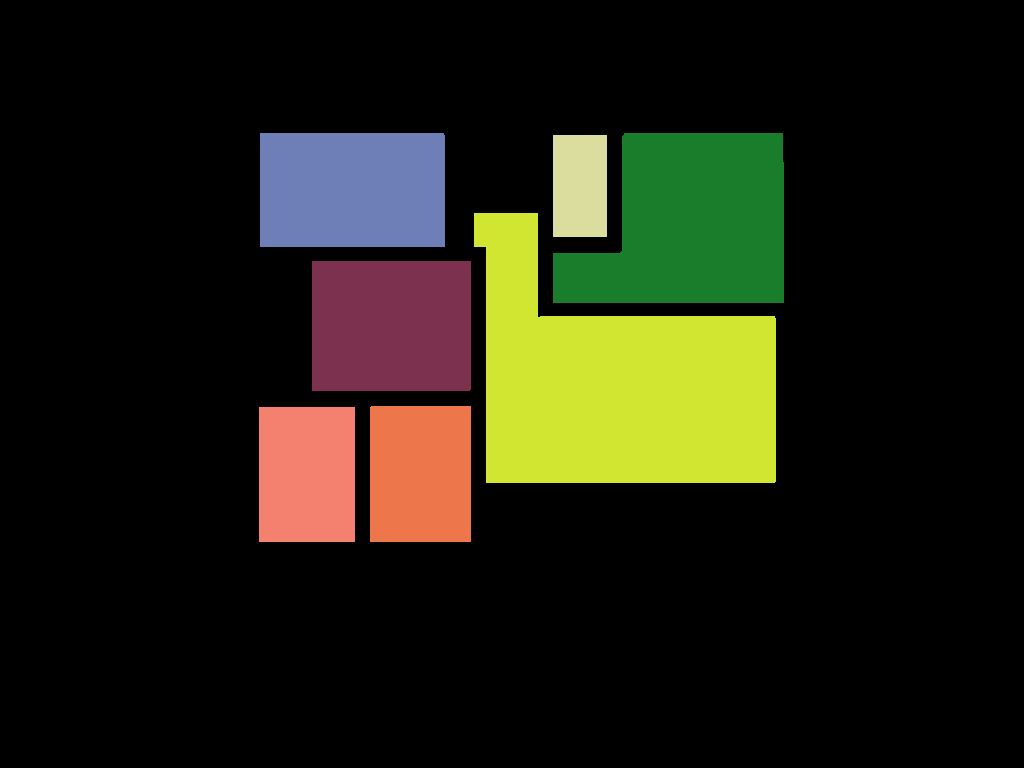

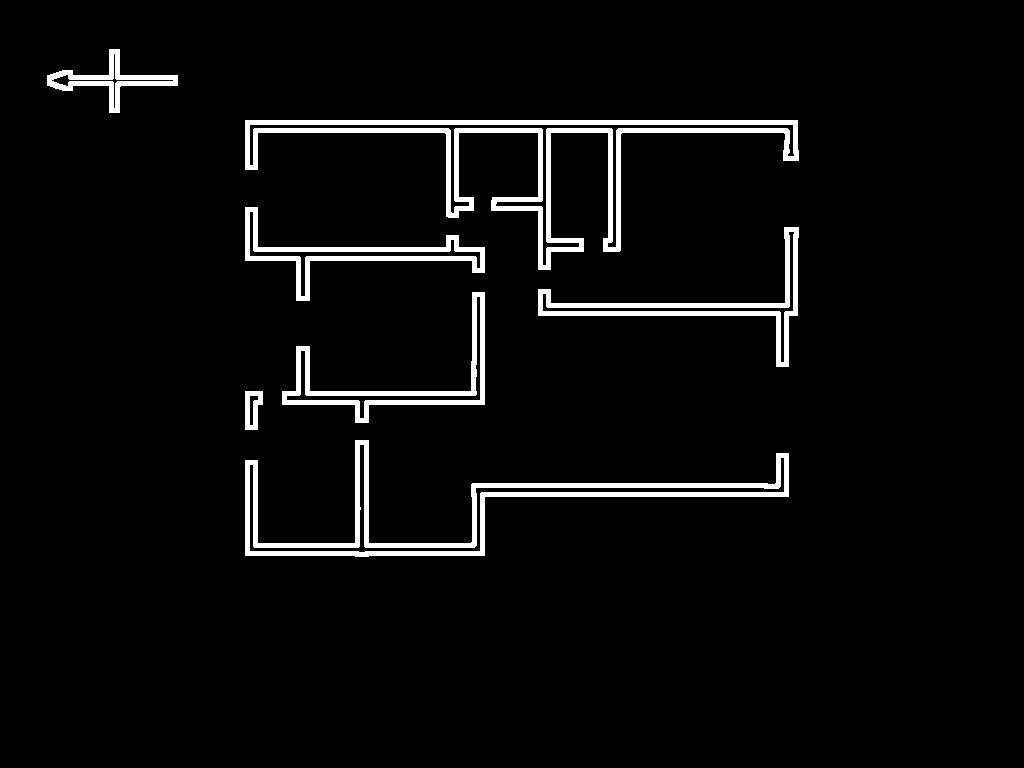

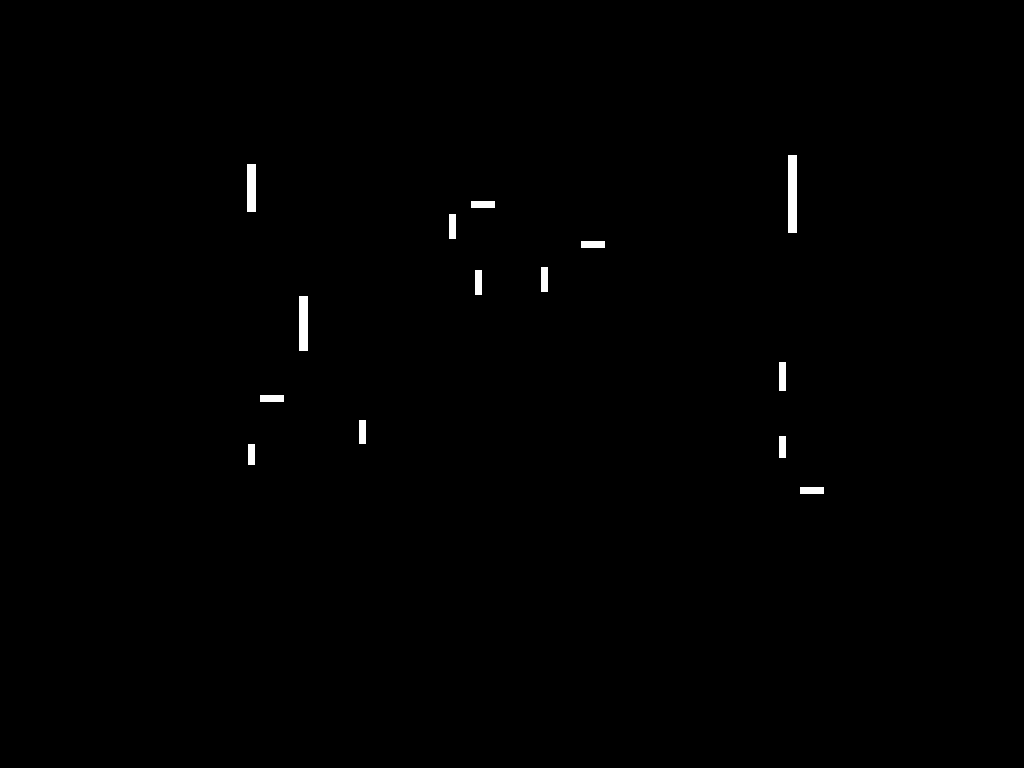

In [11]:
# print dtype of numpy ndarray
# print(type(contour_img))
print(colored_rooms.dtype)
print(wall_img_3d.dtype)
print(parts_img_ui8.dtype)

# print shape of numpy ndarray
# print(contour_img.shape)
print(colored_rooms.shape)
print(wall_img_3d.shape)
print(parts_img_ui8.shape)

# display images
# display(Image.fromarray(contour_img))
display(Image.fromarray(colored_rooms))
display(Image.fromarray(wall_img_3d))
display(Image.fromarray(parts_img_ui8))

## Overlap & show images

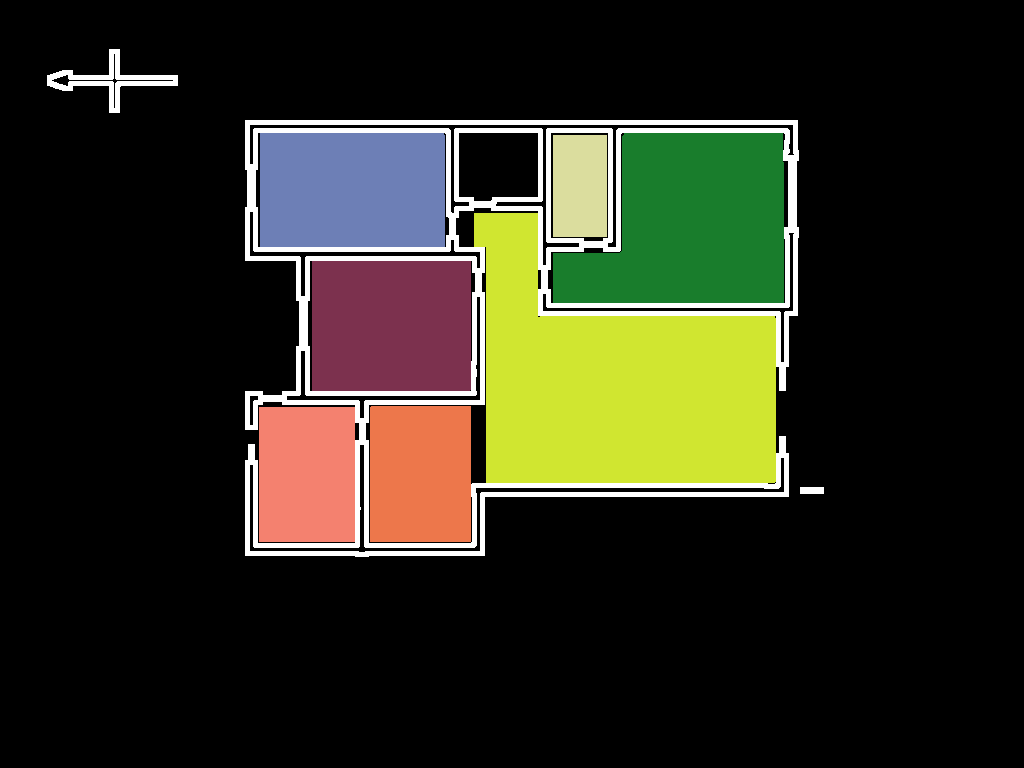

In [8]:
# wall + room + parts
overlap_1 = cv2.bitwise_or(colored_rooms, wall_img_3d)
overlap_unit8 = cv2.bitwise_or(overlap_1, parts_img_ui8)
display(Image.fromarray(overlap_unit8))

In [10]:
overlap_float32 = overlap_unit8.astype('float32') / 255
cv2.imshow("overlap", overlap_float32)
cv2.waitKey(0)
cv2.destroyAllWindows()